In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

/u/abhi24/matlaberp2/posthoc_privacy/.projenv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
bs = 100
# MNIST Dataset
train_dataset = datasets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)


In [17]:


class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        
        # encoder part
        self.fc1 = nn.Linear(x_dim, h_dim1)
        self.fc2 = nn.Linear(h_dim1, h_dim2)
        self.fc31 = nn.Linear(h_dim2, z_dim)
        self.fc32 = nn.Linear(h_dim2, z_dim)
        # decoder part
        self.fc4 = nn.Linear(z_dim, h_dim2)
        self.fc5 = nn.Linear(h_dim2, h_dim1)
        self.fc6 = nn.Linear(h_dim1, x_dim)
        
    def encoder(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc31(h), self.fc32(h) # mu, log_var
    
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # return z sample
        
    def decoder(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return F.sigmoid(self.fc6(h)) 
    
    def forward(self, x):
        mu, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

# build model
vae = VAE(x_dim=784, h_dim1= 512, h_dim2=256, z_dim=10)
if torch.cuda.is_available():
    vae.cuda()



In [18]:
optimizer = optim.Adam(vae.parameters())
# return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return BCE + KLD

In [19]:
def train(epoch):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = vae(data)
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))


In [20]:
def test():
    vae.eval()
    test_loss= 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.cuda()
            recon, mu, log_var = vae(data)
            
            # sum up batch loss
            test_loss += loss_function(recon, data, mu, log_var).item()
        
    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


In [21]:
for epoch in range(1, 51):
    train(epoch)
    test()

/u/abhi24/matlaberp2/posthoc_privacy/.projenv/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 546.362813
Train Epoch: 1 [10000/60000 (17%)]	Loss: 191.339844
Train Epoch: 1 [20000/60000 (33%)]	Loss: 183.301621
Train Epoch: 1 [30000/60000 (50%)]	Loss: 148.504561
Train Epoch: 1 [40000/60000 (67%)]	Loss: 138.673398
Train Epoch: 1 [50000/60000 (83%)]	Loss: 127.508193
====> Epoch: 1 Average loss: 163.3146
====> Test set loss: 126.1083
Train Epoch: 2 [0/60000 (0%)]	Loss: 126.052402
Train Epoch: 2 [10000/60000 (17%)]	Loss: 121.786250
Train Epoch: 2 [20000/60000 (33%)]	Loss: 123.865781
Train Epoch: 2 [30000/60000 (50%)]	Loss: 116.300879
Train Epoch: 2 [40000/60000 (67%)]	Loss: 115.832480
Train Epoch: 2 [50000/60000 (83%)]	Loss: 118.185781
====> Epoch: 2 Average loss: 120.4883
====> Test set loss: 115.0640
Train Epoch: 3 [0/60000 (0%)]	Loss: 113.366494
Train Epoch: 3 [10000/60000 (17%)]	Loss: 115.309023
Train Epoch: 3 [20000/60000 (33%)]	Loss: 113.320625
Train Epoch: 3 [30000/60000 (50%)]	Loss: 115.061436
Train Epoch: 3 [40000/60000 (67%)]	Loss: 115.21

In [25]:
with torch.no_grad():
    z = torch.randn(64, 10).cuda()
    sample = vae.decoder(z).cuda()
    
    save_image(sample.view(64, 1, 28, 28), './samples/sample_' + '.png')

In [12]:
from matplotlib import pyplot as plt
from IPython import display
from matplotlib.colors import ListedColormap
import numpy as np

In [10]:
classes = ['White', 'Black', 'Asian', 'Indian', 'Others'] # UTKFace
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
#values = [0, 1]
colours = ListedColormap(['#1988F7', '#D9A464', '#28FC92', '#36EBE5', '#E6407A', '#00AAEF', '#BC00EF', '#EF4500', '#32EF00', '#EF00AA'])

KeyboardInterrupt: 

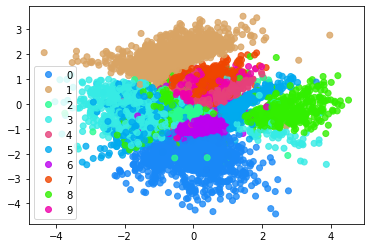

In [16]:
emb_dims = 2
ls = np.array([np.zeros(emb_dims)])
y = np.array([0])
for data, label in train_loader:
    img = data.cuda()
    z, _ = vae.encoder(img.reshape(-1, 784))
    ls = np.append(ls, z[:, :emb_dims].detach().cpu(), axis=0)
    y = np.append(y, label, axis=0)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    scatter = plt.scatter(ls[:, 0], ls[:, 1], c=y, cmap=colours, alpha=0.8)
    plt.legend(handles=scatter.legend_elements()[0], labels=classes)
    plt.pause(0.1)
    #if ls.shape[0] > 5000:
    #    break